In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import mne
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 

**Load data from csv files.**

In [3]:
df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_S_feature.csv", header = 0)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:1: SyntaxWarning: invalid escape sequence '\F'
  df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:2: SyntaxWarning: invalid escape sequence '\F'
  df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:3: SyntaxWarning: invalid escape sequence '\F'
  df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Gra

In [4]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 450)
(6000, 450)
(6000, 450)


**Do some basic data preprocessing before performing feature selection.**

Fill in missing data with the mode of its column.

In [5]:
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

Drop the leftmost column of each dataframe because it is just an ID number.

In [6]:
df_A = df_A.iloc[:, 1:] 
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

In [7]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 449)
(6000, 449)
(6000, 449)


**Feature selection:**

In [8]:
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float) -> pd.DataFrame:
    print("----------STARTING FEATURE SELECTION----------")
    y = df.iloc[:, -1]
    
    # Use recursive feature elimination with cross validation to reduce the dimensionality of the data for each EEG cap channel.
    
    print("----------STARTING RECURSIVE FEATURE ELIMINATION----------")
    start_column_index = 0
    num_features_kept_rfe = 0
    kept_columns_rfe = [] # list of names of columns that are kept

    for i in range(32):
        #print("EEG Cap Channel #", i)
        # Ignore the ratios (e.g. theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns
        
        # decision tree classifier
        dt_classifier = DecisionTreeClassifier() # Note: The features are randomly permuted. For deterministic results, set random_state to a fixed integer.
        # recursive feature elimination with cross validation
        rfecv = RFECV(estimator = dt_classifier, min_features_to_select = 1, cv = StratifiedKFold(), scoring = 'accuracy')
        rfecv.fit(X, y)
        
        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        num_features_kept_rfe += rfecv.n_features_
        
        #print("Optimal number of features : %d" % rfecv.n_features_)
        #print("Columns kept in this iteration:", curr_columns[rfecv.support_])
        
        start_column_index += 14
    print("----------FINISHED RECURSIVE FEATURE ELIMINATION----------")
    
    df_after_rfe = df[kept_columns_rfe]
    print("number of features kept after recursive feature elimination:", num_features_kept_rfe)
    
    X = df_after_rfe
    curr_columns = X.columns

    # Use PCA to further reduce the dimensionality of the dataset.
    print("----------STARTING PCA----------")
    # Scale the data.
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_X= scaler.transform(X)

    # Perform PCA
    pca = PCA(n_components = 50)
    pca.fit(scaled_X)
    pca_result = pca.transform(scaled_X)
    print("----------FINISHED PCA----------")
    
    # Determine number of components needed to keep a certain threshold percentage of variance

    explained_variance_ratio = pca.explained_variance_ratio_
    #print("explained variance ratio: ", explained_variance_ratio)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    #print("cumulative variance ratio: ", cumulative_variance_ratio)
    #print(cumulative_variance_ratio >= 0.8)
    num_pc = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print("Number of principal components to keep", variance_threshold * 100, "% of variance:", num_pc)

    # Visualization
    plt.figure(figsize=(8, 6))

    # Line plot for cumulative explained variance (all points are initially red)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red', label='Cumulative explained variance', linestyle='-')

    # Use blue dots to denote every n-th point where n is divisible by 5
    for i in range(5, len(cumulative_variance_ratio) + 1, 5):
        plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xlabel('# of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.show()
    
    # Find components that give the variance threshold.
    
    components_for_threshold = np.where(cumulative_variance_ratio >= variance_threshold)[0][0] + 1

    # Get the list of column names needed to reach the variance threshold.
    needed_columns = curr_columns[:components_for_threshold]
    # print("Columns needed for", threshold * 100, "% explained variance:")
    # print(needed_columns)
    print("final kept columns:")
    print(df[needed_columns].head())
    print("----------FINISHED FEATURE SELECTION----------")
    return df[needed_columns]

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 188
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 24


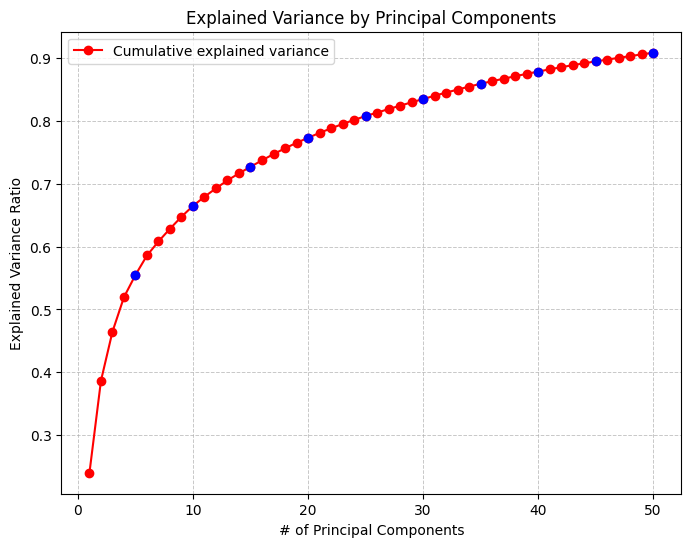

final kept columns:
    0.psd_delta   0.psd_theta  0.psd_alpha   0.psd_beta  0.psd_gamma  \
0  14850.830823  14923.215094  7910.065985  6950.560915  3047.582095   
1  14838.280527  18650.065251  7921.853628  8087.625726  2855.607519   
2   7143.715839  16263.647994  6245.775968  4200.151132  2838.155117   
3   7143.570136  12413.634950  7677.763201  4200.428316  2764.924613   
4  19573.432251  18451.900407  7663.019348  6509.398324  2423.619039   

   0.spectral_entropy_value  0.sample_entropy_value  0.delta_rel_power  \
0                  4.911304                2.639057           0.059237   
1                  4.778889                1.098612           0.150847   
2                  4.455605                0.000000           0.082685   
3                  4.594508                0.000000           0.032636   
4                  4.605586                1.386294           0.198891   

   0.theta_rel_power  0.alpha_rel_power  ...  1.psd_gamma  1.delta_rel_power  \
0           0.199444  

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.sample_entropy_value,0.delta_rel_power,0.theta_rel_power,0.alpha_rel_power,...,1.psd_gamma,1.delta_rel_power,2.psd_delta,2.psd_theta,2.psd_gamma,2.delta_rel_power,2.theta_rel_power,2.alpha_rel_power,2.beta_rel_power,3.psd_delta
0,14850.830823,14923.215094,7910.065985,6950.560915,3047.582095,4.911304,2.639057,0.059237,0.199444,0.183638,...,2661.371734,0.060570,8039.972356,10515.873942,2457.496229,0.078386,0.200349,0.083750,0.337648,10974.394982
1,14838.280527,18650.065251,7921.853628,8087.625726,2855.607519,4.778889,1.098612,0.150847,0.134471,0.107598,...,2220.615506,0.103855,2524.927423,9608.824749,2257.108195,0.065675,0.134126,0.053252,0.481628,9204.513653
2,7143.715839,16263.647994,6245.775968,4200.151132,2838.155117,4.455605,0.000000,0.082685,0.319816,0.088251,...,2121.399887,0.126962,11914.922522,16710.419354,1863.491634,0.149521,0.288982,0.118431,0.259880,7766.041625
3,7143.570136,12413.634950,7677.763201,4200.428316,2764.924613,4.594508,0.000000,0.032636,0.173594,0.122696,...,2656.750004,0.103653,7769.417844,4775.209063,2942.529008,0.104521,0.048319,0.102402,0.205225,6944.807597
4,19573.432251,18451.900407,7663.019348,6509.398324,2423.619039,4.605586,1.386294,0.198891,0.162208,0.083558,...,2949.386556,0.203946,18421.953705,14419.819060,2442.113285,0.234565,0.103856,0.095289,0.331897,12930.284786


In [10]:
df_A_processed = perform_feature_selection(df = df_A, variance_threshold=0.8)
df_A_processed.head()

In [12]:
df_A_processed.to_csv('Datasets/df_A_processed.csv')

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 202
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 25


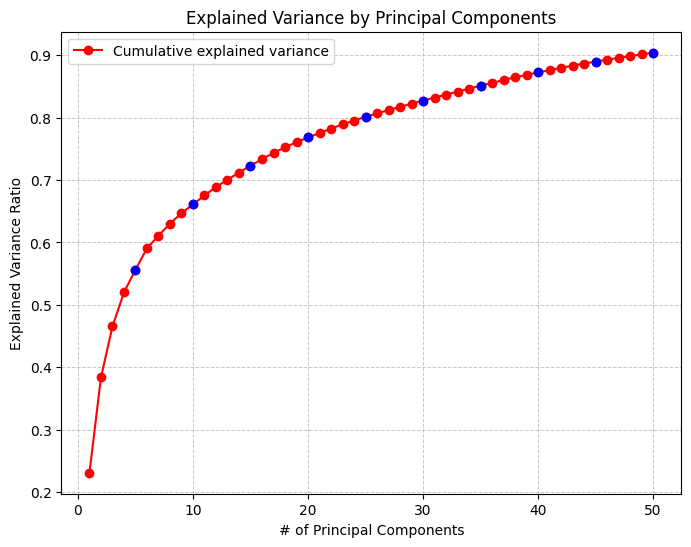

final kept columns:
    0.psd_delta   0.psd_theta   0.psd_alpha    0.psd_beta   0.psd_gamma  \
0  28147.941302  20812.122950  28903.253294  11045.919340  10097.405409   
1  22618.036566  42645.052420  24222.965505  15327.997675   7771.031388   
2  43601.788099  32732.024724  25489.561827  15637.863125   6656.028792   
3  42496.747857  38829.089771  30560.134074  12146.879633   8309.699314   
4  26204.813555  12877.184706   9059.280872  11891.181482  14946.075982   

   0.spectral_entropy_value  0.delta_rel_power  0.beta_rel_power  \
0                  4.682997           0.126007          0.288060   
1                  4.881996           0.103916          0.406341   
2                  4.980213           0.152932          0.352012   
3                  4.763782           0.144180          0.229902   
4                  4.568809           0.096144          0.262839   

    1.psd_delta   1.psd_theta  ...  1.alpha_rel_power  1.beta_rel_power  \
0  31541.470105  29954.967206  ...           

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.delta_rel_power,0.beta_rel_power,1.psd_delta,1.psd_theta,...,1.alpha_rel_power,1.beta_rel_power,2.psd_delta,2.psd_beta,2.spectral_entropy_value,2.delta_rel_power,3.psd_delta,3.psd_theta,3.psd_alpha,3.psd_gamma
0,28147.941302,20812.122950,28903.253294,11045.919340,10097.405409,4.682997,0.126007,0.288060,31541.470105,29954.967206,...,0.167122,0.270814,34938.513792,13745.843523,4.922720,0.137969,40310.063187,29293.163879,23058.933670,12905.214379
1,22618.036566,42645.052420,24222.965505,15327.997675,7771.031388,4.881996,0.103916,0.406341,39936.522448,51649.360158,...,0.127921,0.405022,36819.225771,18368.858430,4.849991,0.082822,16153.754973,25837.083367,24192.407129,13629.804908
2,43601.788099,32732.024724,25489.561827,15637.863125,6656.028792,4.980213,0.152932,0.352012,64146.785166,33271.567752,...,0.108978,0.418899,66980.080825,23829.755856,5.046028,0.142731,36703.748590,33080.101368,20292.144744,7833.194308
3,42496.747857,38829.089771,30560.134074,12146.879633,8309.699314,4.763782,0.144180,0.229902,33907.780297,50108.464686,...,0.128072,0.253308,26387.037209,17794.462862,4.993238,0.031872,27658.844197,46686.886989,11399.514029,10801.569649
4,26204.813555,12877.184706,9059.280872,11891.181482,14946.075982,4.568809,0.096144,0.262839,37629.361928,17296.463743,...,0.036846,0.324067,46289.794364,22215.895817,4.079599,0.081317,31533.059501,16769.571623,10446.491096,17267.127667


In [13]:
df_M_processed = perform_feature_selection(df = df_M, variance_threshold=0.8)
df_M_processed.head()

In [14]:
df_M_processed.to_csv('Datasets/df_M_processed.csv')

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 196
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 22


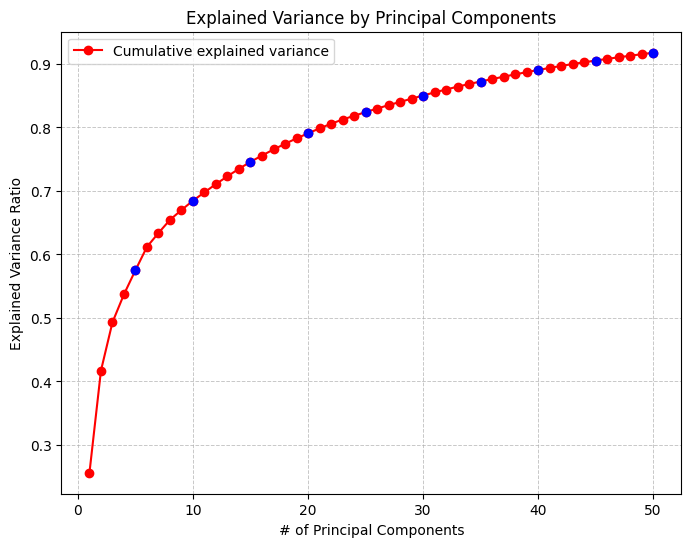

final kept columns:
    0.psd_delta  0.psd_gamma   1.psd_delta   1.psd_theta  1.psd_alpha  \
0   9994.605340  1391.927018   9257.775317   7265.036422  7690.433996   
1  14145.852129  1267.961710  10435.260425   3644.720023  2613.103811   
2  10178.565631   756.718130   4620.447414  10058.027260  7519.625489   
3  16698.788741  1156.874710  17008.405306   2634.528149  7967.808412   
4   5514.739540   938.632292   5870.110121   9069.907815  6995.540680   

    1.psd_beta  1.psd_gamma  1.spectral_entropy_value  1.delta_rel_power  \
0  5163.761781  1918.183035                  4.939184           0.135241   
1  2299.748262   801.173730                  4.803097           0.218845   
2  4332.200640   923.418221                  4.710522           0.061643   
3  3832.212650   977.771965                  4.304630           0.300044   
4  3168.696298   760.198454                  4.495017           0.066728   

   1.theta_rel_power  ...   2.psd_theta  2.psd_alpha   2.psd_beta  \
0           0.1

,0.psd_delta,0.psd_gamma,1.psd_delta,1.psd_theta,1.psd_alpha,1.psd_beta,1.psd_gamma,1.spectral_entropy_value,1.delta_rel_power,1.theta_rel_power,...,2.psd_theta,2.psd_alpha,2.psd_beta,2.psd_gamma,2.spectral_entropy_value,2.sample_entropy_value,2.delta_rel_power,2.theta_rel_power,2.alpha_rel_power,2.beta_rel_power
0,9994.605340,1391.927018,9257.775317,7265.036422,7690.433996,5163.761781,1918.183035,4.939184,0.135241,0.135535,...,8405.860121,7705.936797,4943.532994,1654.873051,4.911795,1.321756,0.141574,0.131399,0.131389,0.389903
1,14145.852129,1267.961710,10435.260425,3644.720023,2613.103811,2299.748262,801.173730,4.803097,0.218845,0.165130,...,2994.597561,3085.116293,2642.653857,729.303425,4.831397,0.000000,0.183558,0.143075,0.160544,0.348480
2,10178.565631,756.718130,4620.447414,10058.027260,7519.625489,4332.200640,923.418221,4.710522,0.061643,0.322946,...,10896.168504,6419.666259,4544.283445,897.488675,4.728050,0.000000,0.059849,0.309120,0.164598,0.360312
3,16698.788741,1156.874710,17008.405306,2634.528149,7967.808412,3832.212650,977.771965,4.304630,0.300044,0.034743,...,3005.764882,6885.195474,4043.460961,808.399091,4.333768,1.386294,0.275740,0.030558,0.176540,0.410303
4,5514.739540,938.632292,5870.110121,9069.907815,6995.540680,3168.696298,760.198454,4.495017,0.066728,0.209294,...,9748.998366,6766.514201,2579.129442,1046.059848,4.624343,0.000000,0.062009,0.241736,0.265787,0.325384


In [15]:
df_S_processed = perform_feature_selection(df = df_S, variance_threshold=0.8)
df_S_processed.head()

In [16]:
df_S_processed.to_csv('Datasets/df_S_processed.csv')

**Implement the decision tree for detecting stress levels.**

**MAYBE COME BACK LATER TO THIS?**

Preprocess the data (There are 32 electrodes and 450 columns total, so 14 columns per electrode).

PCA: https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

FFS: https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/


In [5]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame: # COME BACK LATER
    data_arr = (data.to_numpy()).T
    channel_names = list(df_A.columns)  
    channel_types = ['eeg'] * len(channel_names) 
    info = mne.create_info(ch_names = channel_names, ch_types = channel_types)
    raw_arr = mne.io.RawArray(data_arr, info)
    raw_arr.filter(1, 40)
    
    # Perform ICA 
    ica = mne.preprocessing.ICA(n_components = 3)
    ica.fit(raw_arr)
    ica.exclude = ica.find_bads_eog(raw_arr)[0]
    raw_ica_cleaned = ica.apply(raw_arr.copy())
    
    # Convert cleaned data back into pandas DataFrame
    processed_data = (raw_ica_cleaned.get_data()).T
    df_processed = pd.DataFrame(processed_data, columns = channel_names)
    raw_ica_cleaned.plot()
    return df_processed
    